In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model


In [4]:
train_dir = '/kaggle/input/face-emotion/MMAFEDB/train'
val_dir='/kaggle/input/face-emotion/MMAFEDB/valid'
test_dir = '/kaggle/input/face-emotion/MMAFEDB/test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path+'/'+expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
val_count = count_exp(val_dir, 'valid')
print(train_count)
print(val_count)
print(test_count)

       surprise  fear  angry  neutral    sad  disgust  happy
train      8113  4859   6566    29384  12223     3231  28592
       surprise  fear  angry  neutral   sad  disgust  happy
valid      1474   659   1017     5839  2236      656   5475
      surprise  fear  angry  neutral   sad  disgust  happy
test      1475   691   1041     5858  2177      655   5459


<Axes: >

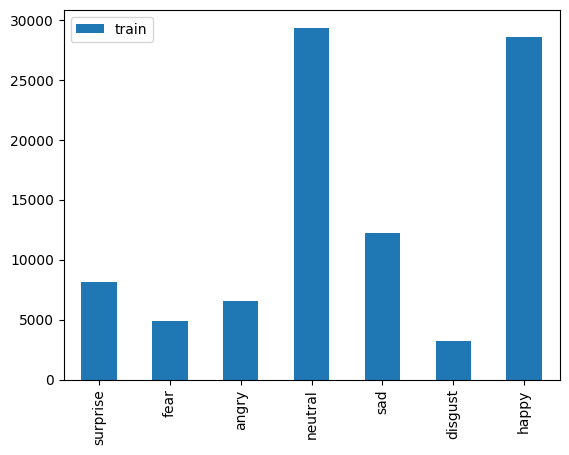

In [5]:
train_count.transpose().plot(kind='bar')

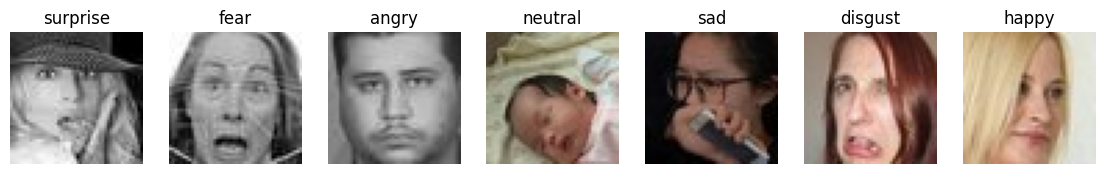

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir +'/'+ expression +'/'+ os.listdir(train_dir +'/'+ expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
validation_set = train_datagen.flow_from_directory(val_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 74378 images belonging to 7 classes.
Found 3468 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.


In [8]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [35]:
from tensorflow.keras.applications import ResNet50V2
conv_base = ResNet50V2(weights=None,
                     include_top=False,
                     input_shape=(48, 48, 3))

In [36]:
conv_base.load_weights('/kaggle/input/weight/tensorflow2/default/1/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [37]:
conv_base.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 14, 14,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 12, 12,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [38]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if 'conv5_block' in layer.name:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer_8 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d_15 False
conv2_block3_3_conv False
conv2_block3_out False
conv3_b

In [67]:

from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Conv2D(3, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
# # model.add(BatchNormalization())  # Add batch normalization
# model.add(Dropout(0.5))  # Add dropout to reduce overfitting
# # model.add(BatchNormalization())  # Another batch normalization
#model.add(Dropout(0.2))  # Another dropout layer
model.add(Dense(7, activation='softmax'))



In [68]:
model.layers

[<Conv2D name=conv2d_1, built=True>,
 <Functional name=resnet50v2, built=True>,
 <Flatten name=flatten_3, built=True>,
 <Dense name=dense_8, built=True>,
 <Dense name=dense_9, built=True>]

In [72]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
 

In [73]:
# checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
#                 ModelCheckpoint(
#                     filepath='model.weights.best.keras',
#                     monitor="val_accuracy",
#                     verbose=1,
#                     save_best_only=True,
#                     mode="max")]

In [74]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

epochs = 25
es = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)
history = model.fit(training_set, epochs=epochs, validation_data=validation_set, callbacks=[es], steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps )

Epoch 1/25
   2/1163 ━━━━━━━━━━━━━━━━━━━━ 1:12 62ms/step - accuracy: 0.1445 - loss: 3.4238  

W0000 00:00:1724259998.473585     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 294/1163 ━━━━━━━━━━━━━━━━━━━━ 2:05 144ms/step - accuracy: 0.3779 - loss: 2.0697

W0000 00:00:1724260040.605595     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1162/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4282 - loss: 1.7232

W0000 00:00:1724260155.475811     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724260164.632657     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 185s 143ms/step - accuracy: 0.4283 - loss: 1.7229 - val_accuracy: 0.3973 - val_loss: 1.6179
Epoch 2/25
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - accuracy: 0.5001 - loss: 1.3877 - val_accuracy: 0.4149 - val_loss: 1.5887
Epoch 3/25
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 74s 63ms/step - accuracy: 0.5160 - loss: 1.3377 - val_accuracy: 0.4097 - val_loss: 1.5692
Epoch 4/25
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 74s 63ms/step - accuracy: 0.5441 - loss: 1.2690 - val_accuracy: 0.4259 - val_loss: 1.5453
Epoch 5/25
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 77s 66ms/step - accuracy: 0.5595 - loss: 1.2322 - val_accuracy: 0.4224 - val_loss: 1.5674
Epoch 6/25
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - accuracy: 0.5725 - loss: 1.1970 - val_accuracy: 0.4265 - val_loss: 1.5787
Epoch 7/25
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 78s 66ms/step - accuracy: 0.5872 - loss: 1.1609 - val_accuracy: 0.4221 - val_loss: 1.6006
Epoch 8/25
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 77s 66ms/step - accuracy: 0.6078 - loss: 1.

In [83]:
weight_decay = 1e-4

num_classes = 7

model1 = tf.keras.models.Sequential()

model1.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model1.add(Activation('elu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model1.add(Activation('elu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.2))
 
model1.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model1.add(Activation('elu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.3))
 
model1.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model1.add(Activation('elu'))
model1.add(BatchNormalization())
model1.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model1.add(Activation('elu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.4))
model1.add(Flatten())
model1.add(Dense(128, activation="linear"))
model1.add(Activation('elu'))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])
 
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,315,335 (5.02 MB)

 Trainable params: 1,314,311 (5.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [85]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model.weights.best.keras',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

In [ ]:
history = model1.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=30,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/30
   3/1162 ━━━━━━━━━━━━━━━━━━━━ 1:12 62ms/step - accuracy: 0.2639 - loss: 3.3976

W0000 00:00:1724262324.559493     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 489/1162 ━━━━━━━━━━━━━━━━━━━━ 1:10 105ms/step - accuracy: 0.3682 - loss: 1.9135

W0000 00:00:1724262375.865050     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 591/1162 ━━━━━━━━━━━━━━━━━━━━ 59s 104ms/step - accuracy: 0.3782 - loss: 1.8641

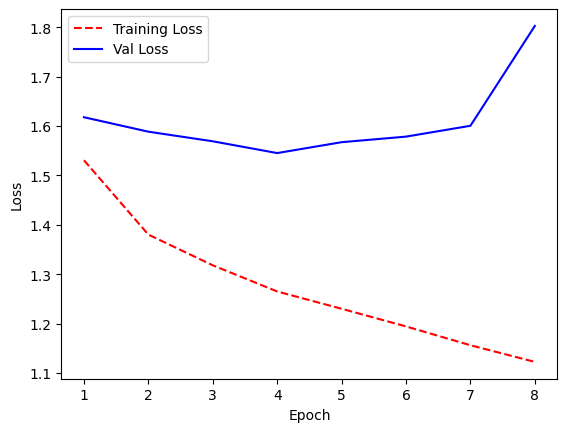

In [75]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

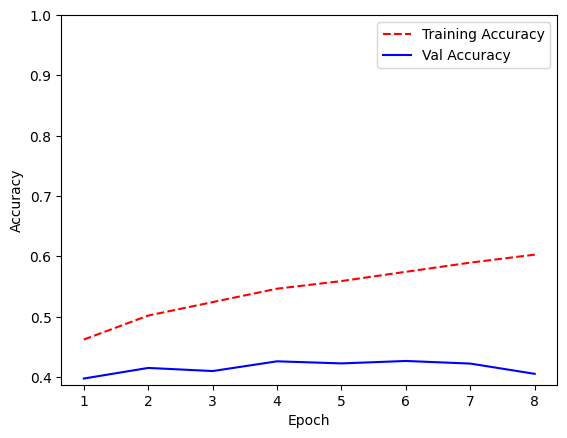

In [76]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()


In [77]:
model.save("face.keras")

In [78]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

271/271 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.4548 - loss: 1.4542
Test accuracy = 45.9870845079422%


   5/1163 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step

W0000 00:00:1724260735.624055     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 80s 65ms/step


W0000 00:00:1724260811.728322     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[ 142    0   63 1888 1921  855  384]
 [  77    0   34  908  962  403  201]
 [ 113    0   50 1380 1412  633  300]
 [ 655    0  244 8093 8357 3795 1730]
 [ 735    0  241 8305 8554 3869 1804]
 [ 276    0  122 3501 3575 1541  764]
 [ 206    0   71 2240 2416 1065  493]]
Classification Report
              precision    recall  f1-score   support

       angry       0.06      0.03      0.04      5253
     disgust       0.00      0.00      0.00      2585
        fear       0.06      0.01      0.02      3888
       happy       0.31      0.35      0.33     22874
     neutral       0.31      0.36      0.34     23508
         sad       0.13      0.16      0.14      9779
    surprise       0.09      0.08      0.08      6491

    accuracy                           0.25     74378
   macro avg       0.14      0.14      0.14     74378
weighted avg       0.23      0.25      0.24     74378



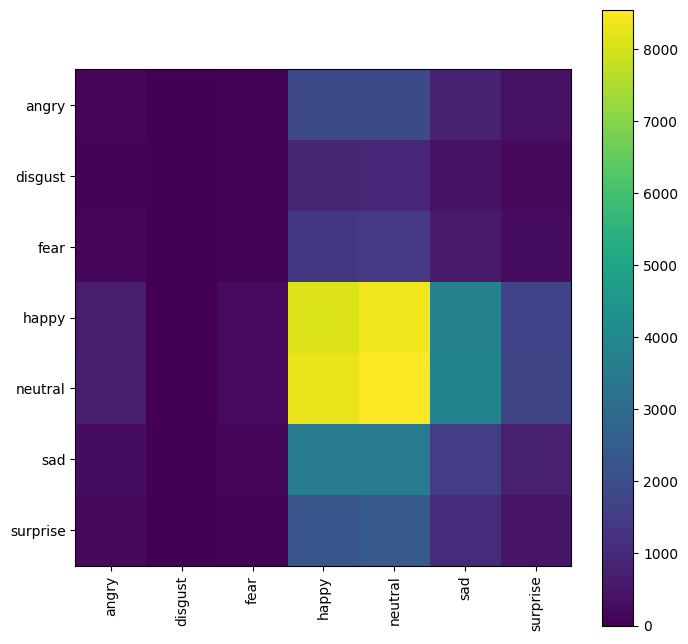

In [79]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step


W0000 00:00:1724260819.534880     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[  6   0   2  56  97  38   4]
 [  6   0   0  35  59  29   2]
 [  3   0   0  31  71  23   3]
 [ 37   0   5 270 567 182  34]
 [ 35   0   7 315 572 200  38]
 [  9   0   1 121 229  74  13]
 [ 11   0   2  82 138  51  10]]
Classification Report
              precision    recall  f1-score   support

       angry       0.06      0.03      0.04       203
     disgust       0.00      0.00      0.00       131
        fear       0.00      0.00      0.00       131
       happy       0.30      0.25      0.27      1095
     neutral       0.33      0.49      0.39      1167
         sad       0.12      0.17      0.14       447
    surprise       0.10      0.03      0.05       294

    accuracy                           0.27      3468
   macro avg       0.13      0.14      0.13      3468
weighted avg       0.23      0.27      0.24      3468



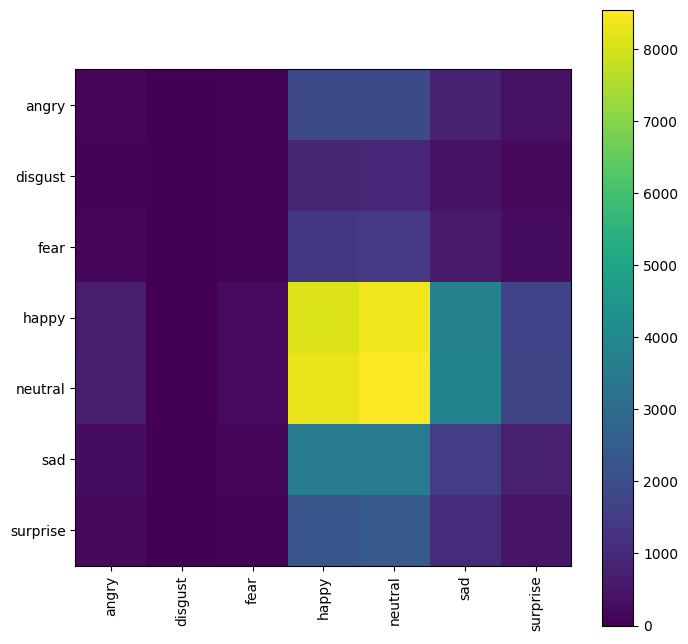

In [80]:
y_pred = model.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)
cm_val = confusion_matrix(validation_set.classes, y_pred)
print('Confusion Matrix')
print(cm_val)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

272/272 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step
Confusion Matrix
[[  31    0   15  286  476  168   65]
 [  13    0    7  169  306  118   42]
 [  19    0    5  179  316  124   48]
 [ 160    0   67 1390 2420 1087  335]
 [ 192    0   78 1450 2681 1069  388]
 [  76    0   20  551 1023  389  118]
 [  33    0   20  406  645  292   79]]
Classification Report
              precision    recall  f1-score   support

       angry       0.06      0.03      0.04      1041
     disgust       0.00      0.00      0.00       655
        fear       0.02      0.01      0.01       691
       happy       0.31      0.25      0.28      5459
     neutral       0.34      0.46      0.39      5858
         sad       0.12      0.18      0.14      2177
    surprise       0.07      0.05      0.06      1475

    accuracy                           0.26     17356
   macro avg       0.13      0.14      0.13     17356
weighted avg       0.24      0.26      0.25     17356



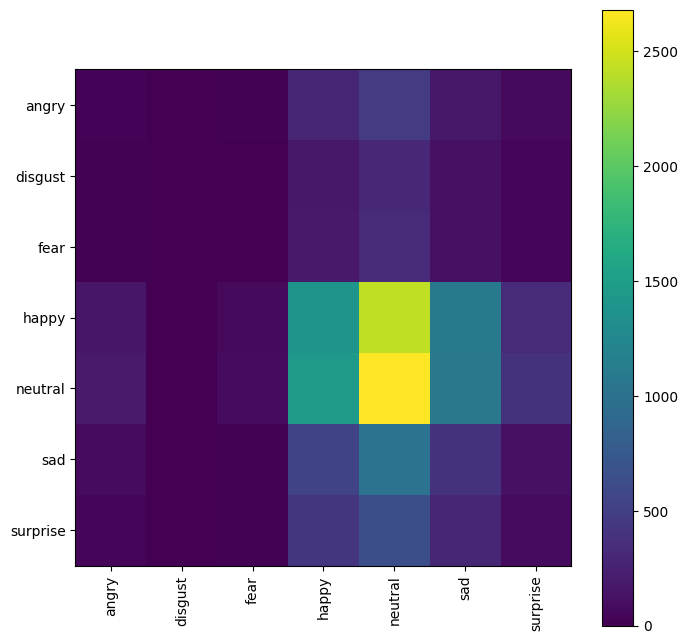

In [81]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


W0000 00:00:1724260846.132721     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


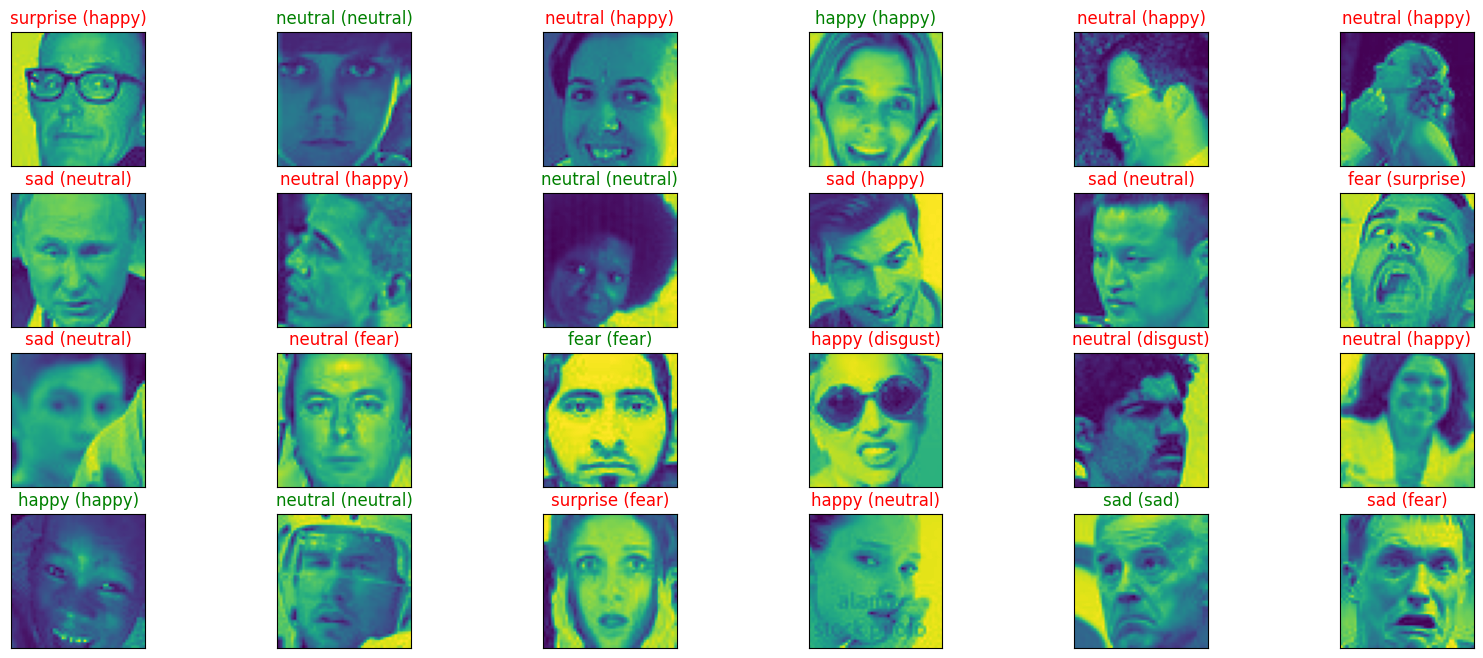

In [82]:
x_test,y_test = next(test_set)
predict = model.predict(x_test)
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))